## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import glob
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import copy
import pandas as pd
import numpy as np
import torch

from sklearn.metrics import roc_auc_score

os.environ["WANDB_SILENT"] = "true"

from owkin.training import train, RocLoss
from owkin.dataset import build_dataset
from owkin.models.mono_models import MLP, SVM, LogReg, RandomForest
from owkin.models.aggregators import SmoothMaxAggregator, MaxAggregator

## Training

In [3]:
normalizer_type = "expo_lambda"

In [4]:
max_depth = 100

In [5]:
list_n_estimators = [int(1e0), int(1e1), int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]
list_criterion = ["gini", "entropy"]
list_val_center = ["C_1", "C_2", "C_5"]

In [6]:
mono_res = {}
smooth_max_res = {}
max_res = {}

for val_center in list_val_center:
    mono_res[val_center] = dict()
    smooth_max_res[val_center] = dict()
    max_res[val_center] = dict()
    for criterion in list_criterion:
        mono_res[val_center][criterion] = dict()
        smooth_max_res[val_center][criterion] = dict()
        max_res[val_center][criterion] = dict()

mono_res["mean"] = dict()
smooth_max_res["mean"] = dict()
max_res["mean"] = dict()
for criterion in list_criterion:
    mono_res["mean"][criterion] = dict()
    smooth_max_res["mean"][criterion] = dict()
    max_res["mean"][criterion] = dict()
    for n_estimators in list_n_estimators:
        mono_res["mean"][criterion][n_estimators] = 0
        smooth_max_res["mean"][criterion][n_estimators] = 0
        max_res["mean"][criterion][n_estimators] = 0

In [7]:
for val_center in list_val_center:
    X_train, X_train_mean, y_train, X_val, X_val_mean, y_val, X_test, X_test_mean, df_test = build_dataset(normalizer_type=normalizer_type, val_center=val_center)
    for criterion in list_criterion:
        for n_estimators in list_n_estimators:    
            mono_model = RandomForest(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
            mono_model.sk_model.fit(X_train_mean, y_train)
            
            smooth_max_model = SmoothMaxAggregator(mono_model)
            max_model = MaxAggregator(mono_model)

            mono_val_pred = mono_model(X_val_mean)
            smooth_max_val_pred = smooth_max_model(X_val)
            max_val_pred = max_model(X_val)
            
            mono_res[val_center][criterion][n_estimators] = roc_auc_score(y_val, mono_val_pred)
            smooth_max_res[val_center][criterion][n_estimators] = roc_auc_score(y_val, smooth_max_val_pred)
            max_res[val_center][criterion][n_estimators] = roc_auc_score(y_val, max_val_pred)

            mono_res["mean"][criterion][n_estimators] += roc_auc_score(y_val, mono_val_pred) / len(list_val_center)
            smooth_max_res["mean"][criterion][n_estimators] += roc_auc_score(y_val, smooth_max_val_pred) / len(list_val_center)
            max_res["mean"][criterion][n_estimators] += roc_auc_score(y_val, max_val_pred) / len(list_val_center)

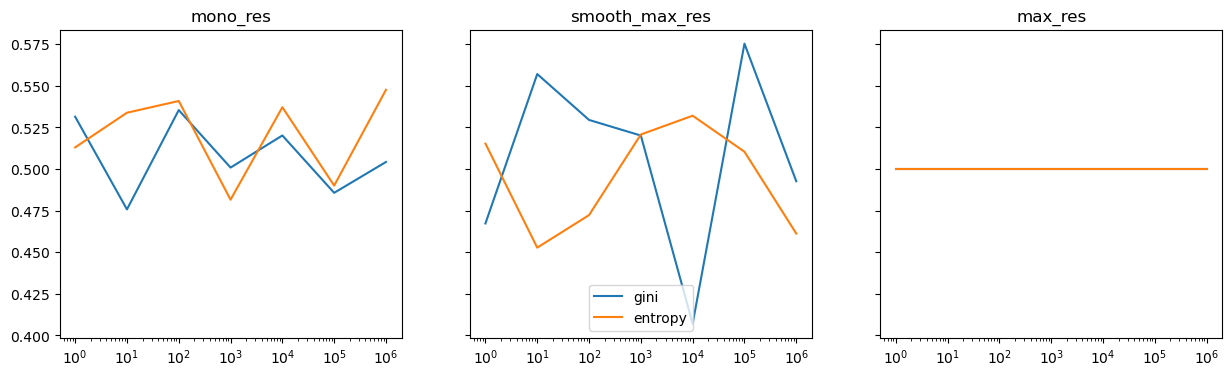

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,4), sharey=True)
for criterion in list_criterion:
    ax[0].plot(list(mono_res["mean"][criterion].keys()), list(mono_res["mean"][criterion].values()), label = criterion)
    ax[1].plot(list(smooth_max_res["mean"][criterion].keys()), list(smooth_max_res["mean"][criterion].values()), label = criterion)
    ax[2].plot(list(max_res["mean"][criterion].keys()), list(max_res["mean"][criterion].values()), label = criterion)

ax[0].set_xscale('log')
ax[0].set_title("mono_res")

ax[1].set_xscale('log')
ax[1].set_title("smooth_max_res")
ax[1].legend(loc = "lower center")

ax[2].set_xscale('log')
ax[2].set_title("max_res")

plt.show()